# Using Callbacks

Callbacks are an integral part of Keras. Callbacks are used to get performance information, log progress, halt in the event of errors, tune parameters, save model state (in case of crash, etc.), finish training once loss is minimized. The list goes on.
Callbacks can be passed to fit, evaluate and predict methods of keras.Model. 

## Goals

The overarching goal is to learn to use callbacks for some typical tasks. These include:
- Reporting about training progress.
- Stoping once training no longer reduces loss.
- Tuning hyperparameters.
- Implementing adaptive learning rate decay.
- Finding an optimal batch-size for training.
- Putting some of this into ```my_keras_utils.py``` so that they can be easily called and reused.

## What's Here?

I continue working with MNIST data, which I began working with in [my first Keras models](first_model.ipynb). 

My **concrete objective** is to tune a model that does well on Kaggle: 97th percentile? That's tough, but I think I can make it work.

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import my_keras_utils as my_utils

In [5]:
## Load our data.
## Since the load process is a little slow, the try-except allows us to re-run all 
## cells without having to wait. 
try:
    ## Raises NameError and loads data if X_train is not defined.
    X_train.shape
except NameError: 
    ((X_train, y_train), (X_dev, y_dev), (X_test, y_test)) = my_utils.load_kaggle_mnist()
X_train.shape




(38000, 784)

In [42]:
## A custom callback, for people who want periodic updates during training. 

from datetime import datetime, time, timedelta

class TimedProgressUpdate(keras.callbacks.Callback):
    '''
    Prints a progress update at time intervals during training.

    The updates occur following the first completed epoch of training after which at least update_interval
    number of minutes have passed.

    Parameters
    ----------
    update_interval: numeric
        The number of minutes between updates. If update_interval is less than one, the fraction of a minute
        between updates. The minimum value is 1/60 (~.016667)

    Raises
    ------
    ValueError
        If the update interval is less than 1/60, Raises a value error (updates can occur at most every one second.)

    '''
    def __init__(self, update_interval=1):
        super(TimedProgressUpdate, self).__init__()
        if update_interval < 1./60:
            error_string = "The minimum update interval is one second. update_interval of {} implies {:.4f} seconds per update."
            raise ValueError(error_string.format(update_interval, update_interval*60))
        self.update_interval = update_interval

    def on_train_begin(self, logs=None):
        self.start_time = datetime.now()
        self.last_update = self.start_time
        print("Begin training of {} at {}. Progress updates every {:.1f} seconds."
                .format(self.model.name, self.start_time.strftime("%H:%M:%S"),self.update_interval*60)
            )

    def on_epoch_end(self, epoch, logs=None):
        now = datetime.now()
        #print((now - self.last_update).seconds)
        if (now - self.last_update).seconds >= 60*self.update_interval:
            print("Starting training on  epoch {}. Current loss is {}.".format(epoch + 1,logs['loss']))
            self.last_update = now

    def on_train_end(self, logs=None):
        end = datetime.now()
        elapsed = end - self.start_time 
        print("Finished fitting at {}. Elapsed time {}.".format(end.strftime("%H:%M:%S"), elapsed))




In [41]:
## Let's use the dropout model from my "first" model notebook.

inputs = keras.Input(shape=(784))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Dropout(rate = .05)(x)
x = layers.Dense(100, activation='relu',)(x)
x = layers.Dropout(rate = .15)(x)
x = layers.Dense(100, activation='relu',)(x)
x = layers.Dropout(rate = .15)(x)
outputs = layers.Dense(10, activation='softmax')(x)
model_dropout = keras.Model(inputs=inputs,outputs=outputs, name='Dropout')
model_dropout.summary()

## specify the optimizer
## .001 is the default learning rate for Adam; 
optimizer = keras.optimizers.Adam(.001)

## Compile and run once to see if everything looks right
model_dropout.compile(optimizer=optimizer, 
                loss="sparse_categorical_crossentropy",
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
            )
init_weights = model_dropout.get_weights()

Model: "Dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 784)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0   

In [49]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                                patience = 10, 
                                                restore_best_weights = True)
progress_update = TimedProgressUpdate(.1)
callbacks = [progress_update, early_stopping]
epochs = 0
initial_epoch = 0
batch_size = 512

In [50]:
if False: ## reinitialize
    model_dropout.set_weights(init_weights)
increment_epochs = 500
epochs += increment_epochs

history = model_dropout.fit(X_train, y_train, 
                        epochs=epochs,
                        initial_epoch = initial_epoch,
                        batch_size=batch_size, 
                        validation_data=(X_dev, y_dev),
                        callbacks = callbacks,
                        verbose = 0)
initial_epoch += increment_epochs

Begin training of Dropout at 11:06:09. Progress updates every 6.0 seconds.
Starting training on  epoch 18. Current loss is 0.054818589240312576.
Starting training on  epoch 36. Current loss is 0.02928883768618107.
Starting training on  epoch 54. Current loss is 0.024166937917470932.
Starting training on  epoch 72. Current loss is 0.020717803388834.
Starting training on  epoch 90. Current loss is 0.01600858010351658.
Starting training on  epoch 108. Current loss is 0.014169310219585896.
Starting training on  epoch 126. Current loss is 0.013337374664843082.
Starting training on  epoch 144. Current loss is 0.01136879250407219.
Starting training on  epoch 162. Current loss is 0.010412385687232018.
Finished fitting at 11:07:07. Elapsed time 0:00:57.379762.


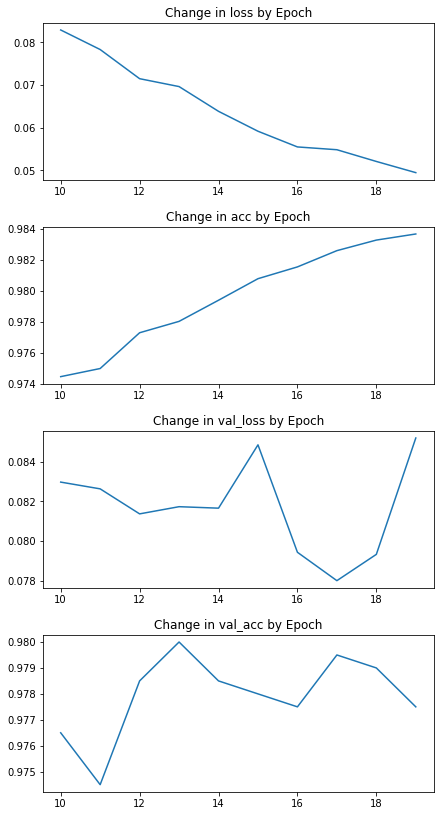

In [60]:
my_utils.history_plot(history, start_epoch=10, end_epoch=20)
